# Modeling for G data<br>

## * Modeling 진행 과정
    1. Preprocessing
        - Data의 변수 확인(분포확인, 연속형 변수끼리 plot)
        - 연속형 Data scaling
    2. Model selection
        - 머신러닝 모형 (rf & bart)
            - k-fold를 활용하여 hyper parameter tuning
                - 기준은 만들어낸 지표 4개로 평균화
                - 가장 best한 hyper parameter 선택하여 fitting 진행
            - train and test set에 대해 k-fold를 활용하여 performance check
        - 회귀모형 (Multinomial Logistic regression & ordinal logistic regression)
            - train and test set에 대해 k-fold를 활용하여 performance check
    3. Model select
        - 해당 팀에서 제시한 4가지 지표를 이용하여 model select
    4. Model Fitting
        - Model fitting
            - train set (661개) 모두 사용
            - 모든 train set으로 data scaling 진행
        - 선택한 모형에 대해 가정 검정
            - VIF (multicollinearity)
            - variable selection
        - 결과 해석
            - 결과 해석 및 visualization
    5. Estimation
        - fitting한 모형을 이용. GRADE를 estimate
        - variable들에 대해 train에 fitting한 function 사용하여 transform
    

## 0. Install packages and specify functions
#### Install packages

In [ ]:
##c++ microsoft 설치 필요. requirement 참조
!pip install xbart

In [1]:
#기본적인 packages 
import pandas as pd
import numpy as np
import os 
import copy
import time
import statistics as st

#split train and test set package
from sklearn.model_selection import train_test_split

#modling packages
from sklearn.ensemble import RandomForestClassifier #RF
import statsmodels.api as sm #MLR
from statsmodels.miscmodels.ordinal_model import OrderedModel #OLR

# 주의 : xbart의 경우는 error 발생 가능성 높음!!!
from xbart import XBART #xbart : error 발생 시 requirement.txt 파일 및 첨부파일 참고


#for testing
from scipy.stats import shapiro #shapiro test(정규성)
from scipy.stats import skew, kurtosis #왜도, 첨도 관련 패키지
from sklearn.preprocessing import QuantileTransformer #Rank_Gauss transformation
from sklearn.preprocessing import StandardScaler #standardscaler
from scipy.stats import bartlett #등분산성 test
import scipy.stats
from statsmodels.stats.outliers_influence import variance_inflation_factor #VIR

#for perfromance check
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#K-fold packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

##plot packages
import matplotlib.pyplot as plt
import matplotlib
from pandas.plotting import scatter_matrix
import platform
import seaborn as sns

## data directory 설정
os.chdir("C:/Users/user/Desktop/ESG데이터")

#### specify functions
1. performance를 판단하는 지표 4가지를 계산하는 function
    - performance를 판단하는 지표 4가지는 각 정확도, 근접정확도, 과소적합/오류비, 3등급 이상 과적합/오류비이다.
    - 해당 값은 팀의 판단하에 중요하다고 생각하는 값을 기준으로 정하고 계산하는 function을 만들었다.
        1. 정확도 : 올바르게 등급을 평가한 샘플 개수/전체 샘플 개수 : 즉, 전체 샘플 중 정답을 맞춘 확률 
        2. 근접정확도 : 실제 평가등급의 +1, -1 등급까지 허용하여 평가한 확률. 즉, 전체 샘플 중 등급을 근사하게 맞춘 확률 
        3. 과소적합오류비 : 기존 등급보다 과소평가를 낸 샘플/오류가 난 샘플 : 즉, 전체 오류 중 과소적합의 비율
        4. 3단계과추정률 : 3등급 이상 차이 나게 평가한 샘플/오류 샘플 : 즉, 전체 샘플 중 grade가 3등급 이상 차이나게 estimate한 확률
    - 정확도, 근접정확도, 과소적합/오류비의 경우는 클수록 좋은 것이고 3등급 이상 과적합/오류비는 작을수록 좋은 것이다.<br>
2. multinomial logistic regression에 대한 function
    1) 모델링 후 summary 결과에 대해 회귀계수만 출력하는 function
    2) 모델링 후 marginal summary 결과에 대해 회귀계수만 출력하는 function
    3) 모델링 후 summary 결과에 대해 p-value만 출력하는 function
    4) 모델링 후 marginal summary 결과에 대해 p-value만 출력하는 function

In [2]:
#arg 설명
##m : confusion matrix 

#1. accuracy 계산 function
def acc(m) :
    return sum(np.diag(m))/np.sum(m)

#2. 근접정확도 계산 function
def nearest_acc(m) :
    total_sum = np.sum(m)
    near_sum = 0
    for i in range(8) :
        near_sum += m[i,i+1] + m[i+1,i]
    diag_sum = sum(np.diag(m))
    return (near_sum + diag_sum) / total_sum

#3. 과소적합/오류비 계산 function
def under_est(m) :
    error_sum = np.sum(m) - sum(np.diag(m))
    under_sum = 0
    for i in range(8) :
        under_sum += np.sum(m[i,(i+1):9])
    return under_sum / error_sum

#4. 3등급 이상 과적합/오류비 function
def over3_est(m) :
    total_sum = np.sum(m)
    error_sum = np.sum(m) - sum(np.diag(m))
    over3C_sum = 0
    for i in range(8) :
        over3C_sum += m[i,i+1] + m[i+1,i]
    for i in range(7) :
        over3C_sum += m[i,i+2] + m[i+2,i]
    diag_sum = sum(np.diag(m))
    return (total_sum - (over3C_sum + diag_sum)) / error_sum

#전체 performance 지표를 출력하는 function
def eval_stat(m) :
    print("정확도 : ",round(acc(m) * 100,2),"%")
    print("근접정확도 : ",round(nearest_acc(m) * 100,2),"%")
    print("과소적합/오류 비 : ",round(under_est(m) * 100,2),"%")
    print("3등급이상과적합/오류 비 : ",round(over3_est(m) * 100,2),"%")
    

#multinomial logistic regression에서 전체 summary에 대한 회귀계수 값을 가져오는 function  
#arg 설명
##cmodel = model.fit (이때 model은 MNLogit 모형)
def check_beta(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b[0:2]
    k = b.shape[1]/8
    ind=[]
    m_table = pd.DataFrame(index=range(0,8), columns=b.loc[0,1:(k-1)])
    for i in range(8) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table

#multinomial logistic regression에서 marginal summary에 대한 회귀계수 값을 가져오는 function 
def check_beta_mar(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b[0:2]
    k = b.shape[1]/9
    ind=[]
    m_table = pd.DataFrame(index=range(0,9), columns=b.loc[0,1:(k-1)])
    for i in range(9) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table

#multinomial logistic regression에서 전체 summary에 대한 p-value 값을 가져오는 function  
def check_p_value(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b.loc[[0,4],:]
    b.reset_index(drop=True, inplace=True)
    k = b.shape[1]/8
    m_table = pd.DataFrame(index=range(0,8), columns=b.loc[0,1:(k-1)])
    ind=[]
    for i in range(8) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table

#multinomial logistic regression에서 marginal summary에 대한 p-value 값을 가져오는 function  
def check_p_value_mar(cmodel) :
    a = cmodel.summary()
    b = a.tables[1]
    b = pd.DataFrame(b)
    b = b.transpose()
    b = b.loc[[0,4],:]
    b.reset_index(drop=True, inplace=True)
    k = b.shape[1]/9
    m_table = pd.DataFrame(index=range(0,9), columns=b.loc[0,1:(k-1)])
    ind=[]
    for i in range(9) : 
        coeff = b.loc[1,(i*k):((i+1)*k-1)]
        m_table.iloc[i] = coeff[1:].tolist()
        ind.append(b.loc[0,(i*k)])
    m_table.index=ind
    return m_table


#### 데이터 불러오기 및 정보 확인

In [3]:
df = pd.read_excel("G_final.xlsx")
data = copy.deepcopy(df)

#### 변수들의 type을 알맞게 변환
    
- object type으로 변경해야 할 변수 존재<br>
- 종목코드, 지가경공시, 주총ESG안건, (이사회독립성 : 이미 object type으로 존재), 배당공지, 내부감사부서, 감사전문가, 공시우수법인, 횡령3y, 지배구조공시, 불성실공시, 지가경발간

In [4]:
## object에 해당하는 변수들 변경
chang_var = ['종목코드', '지가경공시', '주총ESG안건', '배당공지', '불성실공시',
             '내부감사부서', '감사전문가', '공시우수법인', '횡령3y', '지배구조공시', '지가경발간']
data[chang_var]=data[chang_var].astype('object')

## preprocessing을 위한 train and test set 분리
print(data['G_GRADE'].unique())
train = data.loc[data['G_GRADE']!=0,]
test = data.loc[data['G_GRADE']==0,]

# index 초기화 하기
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

[1 2 3 4 5 6 7 9 8 0]


## 1. Preprocessing

#### num_var과 categ_var 이름 할당
- 수월한 검정 및 코드를 위해서 categorical variable 들의 이름은 categ_var에 numerical variable의 이름은 num_var에 할당

In [5]:
# 그래프에서의 한글 깨짐 제거
# print(platform.system()) #window
if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    matplotlib.rc('font', family='AppleGothic')
else: #linux
    matplotlib.rc('font', family='NanumGothic')

# categorical variable과 numeric variable의 colname을 저장
categ_var= [var for var in train.columns if train[var].dtype=='object']
num_var= [var for var in train.columns if train[var].dtype!='object']
categ_var = categ_var[3:-1] # 지가경공시 ~ 지가경발간
num_var = num_var[1:] # 사외이사비율 ~ G_risk

#### 변수간의 관계 - plot 

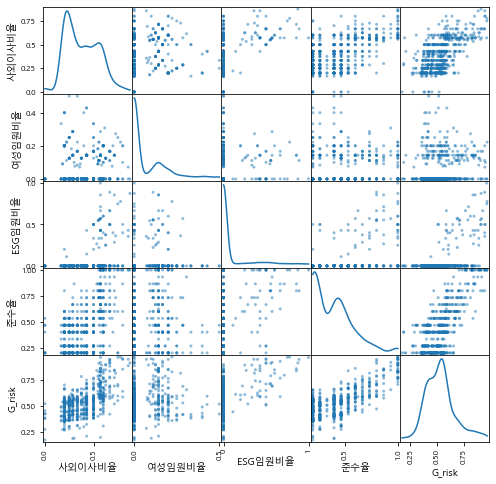

C:\Users\user\AppData\Local\Temp\ipykernel_16640\2292287511.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['G_GRADE'] = train['G_GRADE'].astype('object')


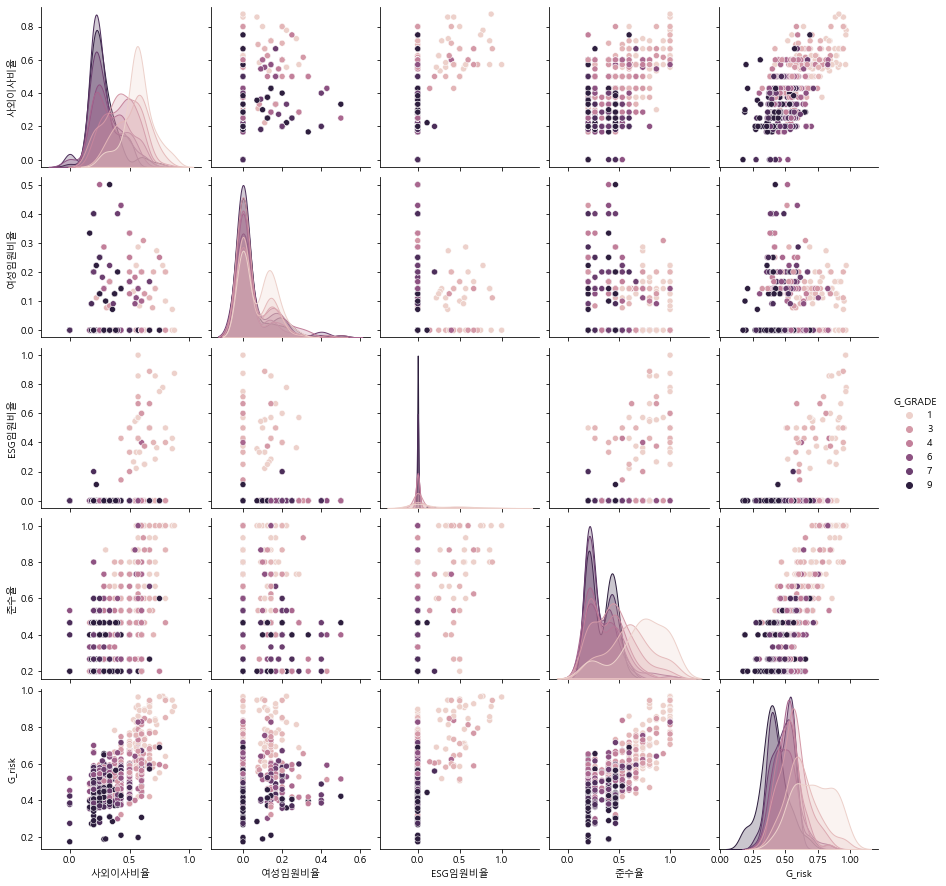

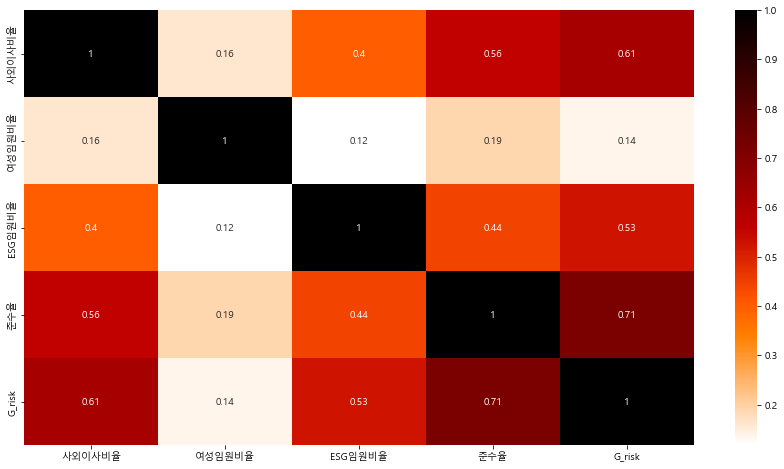

In [6]:
scatter_matrix(train.drop(columns=['G_GRADE'], inplace=False), alpha=0.5, figsize=(8,8), 
               diagonal='kde')
plt.show()

# 산점도 행렬을 G_GRADE의 범주에 따라 그림 : 연속형 변수
p_data = train[num_var]
p_data['G_GRADE'] = train['G_GRADE'].astype('object')
sns.pairplot(p_data, diag_kind='auto', hue='G_GRADE')
plt.show()

# 상관계수 행렬 그래프 : 연속 vs. 연속
p_data = p_data.drop(columns='G_GRADE').corr(method='pearson')
plt.figure(figsize = (15,8))
sns.heatmap(p_data, xticklabels=p_data.columns, yticklabels=p_data.columns,
           annot=True, cmap='gist_heat_r')
plt.show()

- 첫 번째 plot을 봤을 때, 모든 numeric variable들이 정규성을 만족하지 못한다는 것을 알 수 있다. 특히 여성임원비율, ESG임원비율, 준수율의 경우는 왼쪽으로 많이 치우친 모습을 보여 모형에 잘못된 정보를 줄 가능성이 높아 보인다.<br>
 
- 두 번째 plot을 보면 대부분의 그래프들이 bimodal의 경향을 보이기는 하지만 첫 번째 plot 보다는 조금 더 정규분포에 모습에 가깝다. 이는 각 등급에 따라 해당 x 변수들의 분포가 달라진다고 해석할 수 있다. 따라서 해당 설명변수를 사용하더라도 모형에 잘못된 정보를 주지는 않을 것이라고 판단한다.<br>
 
 - 세 번째 plot은 x변수들의 correlation값을 heatmap으로 나타낸 것이다. 대부분 나쁘지 않은 상관계수를 가지고 있지만, 준수율과 G_risk의 경우 상관계수가 0.71로 굉장히 높다. 이로 인해 추후 모델에 있어서 다중공선성이 우려된다.

#### 데이터의 정규성 검정 및 수치 확인

In [7]:
# 연속형 데이터의 정규성을 검정하기 위해 shapiro test 진행
## p-value가 굉장히 작음 -> H0(정규성 충족) 기각
## 따라서 해당 데이터의 연속형 변수들은 정규성을 만족하지 못하므로 transformation이 필요.
for var in num_var :
    shapiro_test = shapiro(train[var])
    print(var, shapiro_test)

# 왜도 : 분포의 비대칭도
print("왜도는")
pd.DataFrame(skew(train[num_var]), index=num_var).T

사외이사비율 ShapiroResult(statistic=0.9413503408432007, pvalue=1.75384810349727e-15)
여성임원비율 ShapiroResult(statistic=0.6173595190048218, pvalue=8.35901681044643e-36)
ESG임원비율 ShapiroResult(statistic=0.3075653314590454, pvalue=4.203895392974451e-44)
준수율 ShapiroResult(statistic=0.864078164100647, pvalue=1.7581969350219436e-23)
G_risk ShapiroResult(statistic=0.9548236727714539, pvalue=2.3077560370489414e-13)
왜도는


,사외이사비율,여성임원비율,ESG임원비율,준수율,G_risk
0,0.368482,1.910255,3.822895,0.957624,0.777116


In [8]:
# 첨도 : 분포의 뾰족한 정도
print("첨도는")
pd.DataFrame(kurtosis(train[num_var], fisher=True), index=num_var).T

첨도는


,사외이사비율,여성임원비율,ESG임원비율,준수율,G_risk
0,-0.639531,3.802749,14.563492,0.179893,0.950796


1. 수치에 대한 설명
    - raw data에 대한 plot을 그려보았다. 이에 대해 더 정확하게 정규성을 검정하기 위해서 shapiro test를 시행하고 왜도와 첨도를 출력했다. shapiro test는 귀무가설이 '정규성을 충족한다.' 로 p-value가 0.05 이상이면 해당 변수들의 모분포가 정규성을 충족한다고 볼 수 있다. 
    - 왜도의 경우는 0이 정규분포이고 0보다 크면 왼쪽으로 작으면 오른쪽으로 치우침을 의미한다. 
    - 첨도는 0이 정규분포이며 0보다 크면 정규분포보다 뾰족하고 0보다 작으면 정규분포보다 뭉툭하다.

2. 해석
    - plot에서의 해석과 마찬가지로 shapiro test 결과 G_data에 사용된 numeric variable은 모두 정규성을 만족하지 않았다. 
    - 모든 변수들의 왜도가 0보다 크므로 정규분포와 모양이 유사하던 G_risk조차 왼쪽으로 치우쳐 있음을 알 수 있다. 특히 ESG임원비율의 경우 왜도가 3.823으로 다른 변수들보다 더 많이 왼쪽으로 치우쳐있다. 
    - 첨도의 경우 사외이사비율은 첨도가 0보다 작아 덜 뾰족한 분포를 가짐을 알 수 있는데, 이는 plot에서와 같이 사외이사비율이 bimodal이기 때문으로 보인다. 그 외 다른 변수들은 첨도가 0보다 커 뾰족한 분포를 가짐을 알 수 있다. 특히, ESG임원비율같은 경우, 첨도가 14정도로 매우 심각한 수준임을 알 수 있다.
    - 이에 따라 scaling이 필요하다고 판단했다.

#### 데이터 Scaling using Quantile Transformation
- 위 plot과 shapiro test등을 통해서 해당 변수들이 정규분포를 따르도록 scaling을 해줘야 한다는 insight를 얻었다. 
- scaling 방법은 Quantile Transformation 방법을 사용했다. Quantile Transformation은 설명 변수의 누적분포함수를 구하여 Uniform 분포에 할당한다. 그렇게 얻어진 값을 사용자가 원하는 분포에 quantile 함수를 사용하여 mapping 한다.
- 변환 방법은 train set에 대해서 fitting한 후, test set에 대해 transform하는 방법을 사용하였다.

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (661). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_16640\2360033973.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('G4.png', dpi=500)
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


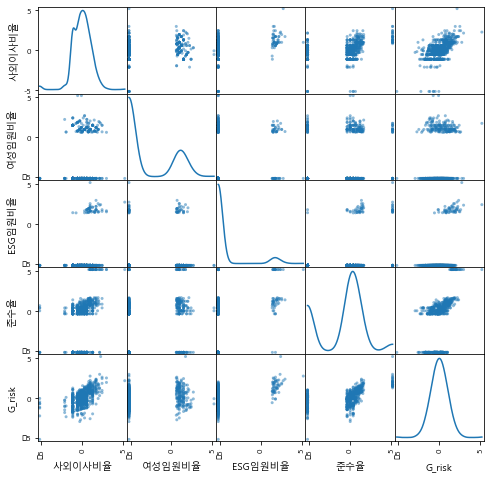

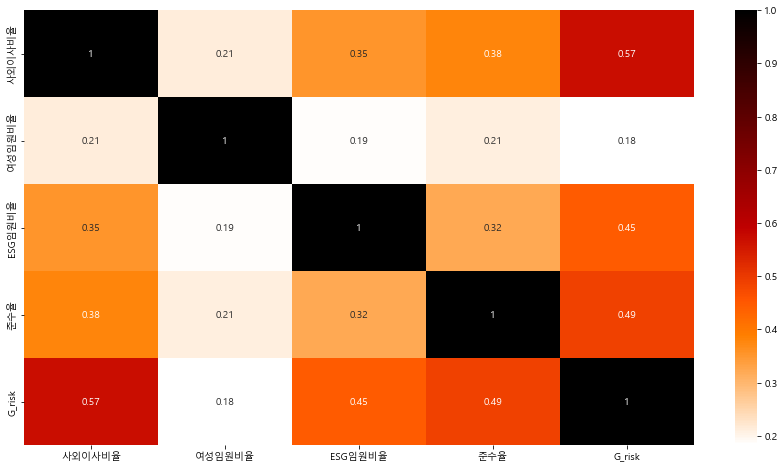

정규성 검정
사외이사비율 ShapiroResult(statistic=0.9125028848648071, pvalue=4.5806274133223825e-19)
여성임원비율 ShapiroResult(statistic=0.597968578338623, pvalue=1.841332010856104e-36)
ESG임원비율 ShapiroResult(statistic=0.3152739405632019, pvalue=6.165713243029195e-44)
준수율 ShapiroResult(statistic=0.8017846345901489, pvalue=1.1745572655337216e-27)
G_risk ShapiroResult(statistic=0.9903939366340637, pvalue=0.0002617699792608619)
왜도는


,사외이사비율,여성임원비율,ESG임원비율,준수율,G_risk
0,-0.828436,1.032043,3.064612,-0.276673,0.00086


In [9]:
qt = QuantileTransformer(output_distribution='normal')
qt.fit(train[num_var]) #train set에 대해 scaling fitting

#각 train과 test set에 대해 transform
train[num_var] = qt.transform(train[num_var])
test[num_var] = qt.transform(test[num_var])
scatter_matrix(train[num_var], alpha=0.5, figsize=(8,8), diagonal='kde')
plt.show()

# 상관계수 행렬 그래프 : 연속 vs. 연속
train_corr = train[num_var].corr(method='pearson')
plt.figure(figsize = (15,8))
sns.heatmap(train_corr, xticklabels=num_var, yticklabels=num_var,
           annot=True, cmap='gist_heat_r')
plt.show()
print("정규성 검정")
for var in num_var :
    shapiro_test = shapiro(train[var])
    print(var, shapiro_test)

# 왜도 : 분포의 비대칭도
print("왜도는")
pd.DataFrame(skew(train[num_var]), index=num_var).T

In [10]:
# 첨도 : 분포의 뾰족한 정도
print("첨도는")
pd.DataFrame(kurtosis(train[num_var], fisher=True), index=num_var).T

첨도는


,사외이사비율,여성임원비율,ESG임원비율,준수율,G_risk
0,4.880062,-0.826055,7.549263,-0.744225,1.416788


- Quantile Transformation 방법을 이용하여 sacling한 결과 첫 번째 plot과 같이 scaling을 하기 전보다는 정규분포의 모양을 띄는 것을 보인다. 특히 G_risk와 사외이사비율은 정규분포의 모습을 하고 있다고 봐도 무방하다. 여성임원비율, ESG임원비율, 준수율의 경우는 정규분포의 모습을 하고 있지는 않다.

- 두 번째 plot은 numeric variable의 상관계수에 대해서 plot을 작성한 것이다. 해당 그래프의 경우, scaling전의 값과는 달리 대체적으로 문제가 될 만한 값을 없다고 판단했고 특히 준수율과 G_risk의 상관계수가 0.49정도로 많이 낮아져 다중공선성이 발생할 우려가 줄어들었다.

- 더 자세하게 알아보기 위해 전처리 전 데이터와 마찬가지로 shapiro test와 왜도, 첨도를 출력했다. 대부분의 shapiro test는 여전히 귀무가설을 기각하지만 왜도와 첨도의 경우는 많이 나아졌다. 특히, plot에서와 마찬가지로 사외이사비율과 G_risk의 경우는 왜도가 0에 가까워진 모습을 보인다. 특히 ESG임원비율의 경우 첨도가 14에서 7.5로 많이 낮아진 모습이다.

- Shapiro test에서는 여전히 작은 p-value로 정규성을 보장하고 있지는 않다. 이는 각 비율들의 첨도가 0보다 크기 때문인 것으로 보인다. 정규성을 가설검정으로 보장하지는 않지만 첨도와 왜도가 어느 정도 줄어들었고, 더 이상의 변환은 데이터에 불필요한 보정을 할 수 있어 하지 않았다. 

In [11]:
## dummy variable을 위해 scaling한 데이터를 다시 합침
total_data = pd.concat([train, test], ignore_index=True)

####  object type 변수들에 대해서 dummy variable 생성
- object type변수들을 위해 dummy variable을 생성했다.
- regression용 데이터의 경우 rdata라고 명시하고 multicollinearity를 예방하기 위해 object type 변수에 대해 dummy variable을 생성한 후, 마지막 dummy는 제거해주었다. 
- machine learning용 데이터의 경우 mdata라고 명시하고, 해당 모델에서 자동으로 encoding을 해주기 때문에 factor type으로 변환한 데이터를 사용하였다.

In [12]:
# linear regression용 data의 경우 multicollinearity를 예방하기 위해 categorical variable에서 
# category의 개수가 3이상인 경우, 마지막 변수를 제거. : 없음
# 이사회독립성 : object type이라서 dummy variable 생성 필요
# 그 외 변수들은 object type이지만 int 값으로 구성되어 있어 변수 타입만 변환해주면 됨.
print("The value counts are")
# for var in categ_var :
#     print(total_data[var].value_counts())
print("Variables have more than three levels")
for var in categ_var :
    if len(total_data[var].unique()) >= 3 :
        print(var, end=', ')

# regression용 data
rdata = copy.deepcopy(total_data)
rdata = pd.get_dummies(rdata, columns=['이사회독립성']) #dummy 생성
rdata.drop(columns=['이사회독립성_겸임'], inplace=True) #마지막 dummy drop

# binary variable들을 다시 int type으로 변경
chan_var = [var for var in rdata.columns if rdata[var].dtype == 'object']
chan_var = chan_var[3:-1]
rdata[chan_var] = rdata[chan_var].astype('int')

## machinelearning용 data -> object를 factor화
mdata = copy.deepcopy(total_data)
object_columns = mdata.dtypes[mdata.dtypes == 'object'].index.tolist()
for column in object_columns[3:-1]:
    mdata[column] = pd.factorize(mdata[column])[0]

The value counts are
Variables have more than three levels


C:\Users\user\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


#### rdata와 mdata를 train과 test set으로 분리.
이때 train은 G_grade에 대해 real value가 주어진 데이터이고, test의 경우는 prediction을 통해 결과를 제출해야하는 데이터이다.

In [13]:
r_train = rdata.loc[rdata['G_GRADE']!=0,]
r_test = rdata.loc[rdata['G_GRADE']==0,]
m_train = mdata.loc[rdata['G_GRADE']!=0,]
m_test = mdata.loc[rdata['G_GRADE']==0,]

# index를 reset
r_train = r_train.reset_index(drop=True)
r_test = r_test.reset_index(drop=True)
m_train = m_train.reset_index(drop=True)
m_test = m_test.reset_index(drop=True)

## 2. Model Selection
- 머신러닝에서 2개의 모델, 회귀분석에서 2개의 모델 총 4개의 모델을 이용하여 당사에서 제공한 참값이 입력되어 있는 train set을 이용하여 다시 train과 test로 나누어서 hyperparameter tuning 및 예측 결과를 비교하려 한다. 이때 분석 데이터는 업종별, 등급별로 층을 나누어 분포한 데이터라고 생각되어 층화추출을 이용하여 train과 test set을 나누었다.

### 2-1. RandomForest
     * 목차
        - hyper parameter setting (using cross validation)
        - modeling (using k-fold)
        - performance check

- 특징
    - 데이터가 적더라도 반복 학습, 검증을 통해 overfitting을 방지
    - 상대적으로 튜닝이 거의 필요 없음
    - variable importance를 통해 어느 정도 변수에 대한 설명 가능

#### hyper parameter tuning
- 머신러닝에서 hyperparameter를 tuning하기 위해 여러가지 parameter 선택 값과 cross validation을 사용하였다. 이때 cross-validation의 값은 5를 사용했다.

In [14]:
## parameter tuning
# n_estimator : 트리의 개수. default는 10, 많을수록 성능이 좋아질 수 있으나 항상 그런 건 아님.
# max_depth : 트리의 깊이
# min_samples_leaf : leaf node가 되기 위한 최소한의 샘플 데이터 수
# min_samples_split : 노드를 분할하기 위한 최소한의 데이터 수

n_estimators = [50,100,200,300,500,700]
max_depth = [6,8,10,12]
min_samples_leaf = [3,5,7,10]
min_samples_split = [3,5,7,10]

## K-Fold
y = m_train['G_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)

# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
best_hype = []
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []

for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for i in range(len(n_estimators)) :
        print(i, end='')
        for j in range(len(max_depth)) :
            for k in range(len(min_samples_leaf)) :
                for l in range(len(min_samples_split)) :
                    model = RandomForestClassifier(max_depth=max_depth[j], 
                                                   min_samples_leaf=min_samples_leaf[k],
                                                   min_samples_split=min_samples_split[l],
                                                   n_estimators=n_estimators[i], 
                                                   random_state=10)
                    model.fit(x_train, y_train)
                    y_pred = model.predict(x_test) # 예측 라벨
                    m = confusion_matrix(y_test, y_pred)
                    acc_vec.append(acc(m))
                    nearest_acc_vec.append(nearest_acc(m))
                    under_est_vec.append(under_est(m))
                    over3_est_vec.append(over3_est(m))
                    hype = [n_estimators[i],max_depth[j],min_samples_leaf[k],min_samples_split[l]]
                    best_hype.append(hype)
                    
                    
# hyperparameter들의 결과를 출력 및 저장
hype = pd.DataFrame(best_hype, columns=['ne', 'md', 'ml', 'ms'])
rf_hype = pd.DataFrame({'정확도':acc_vec, '근접정확도':nearest_acc_vec,
                       '과소추정오류비':under_est_vec, '3단계과추정률':over3_est_vec})

rf_hype = pd.concat([hype, rf_hype], axis=1)
rf_hype_mean = rf_hype.groupby(['ne', 'md', 'ml', 'ms'], as_index=False).mean()
print(rf_hype_mean.sort_values('정확도',ascending=False).head(1))

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


012345012345012345012345012345    ne  md  ml  ms       정확도    근접정확도   과소추정오류비   3단계과추정률
34  50  10   3   7  0.284324  0.59607  0.560858  0.330086


- 위의 값이 가장 accuracy가 좋았던 hyperparameter 값이다. 이에 따라 해당 값으로 random forest 모형 fitting을 진행했다.

#### K-fold를 활용한 fitting 및 performance 출력

In [15]:
## set hyperparameter 
sel = rf_hype_mean.sort_values('정확도',ascending=False).head(1)
ne=sel.iloc[0,0] #n_estimators
md=sel.iloc[0,1] #max_depth
ml=sel.iloc[0,2] #min_samples_leaf
ms=sel.iloc[0,3] #min_samples_split


## K-Fold를 통한 randomforest fitting
y = m_train['G_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)

# split 개수, 셔플 여부 및 seed 설정 / 5-fold 진행
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time() 
for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # hyper parameter tuning의 결과
    model = RandomForestClassifier(n_estimators=ne, max_depth=md, min_samples_leaf=ml,
                                  min_samples_split=ms)
    model.fit(x_train, y_train) # 모델 학습

    y_pred = model.predict(x_test) # 예측 라벨
    m = confusion_matrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))
    
print("time :", time.time() - start)

print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 0.211226224899292
정확도: [36.09 29.55 23.48 26.52 18.94]     정확도 평균: 26.919999999999998
근접정확도: [60.9  58.33 58.33 63.64 52.27]     근접정확도 평균: 58.699999999999996
과소추정오류비: [35.29 53.76 58.42 65.98 58.88]     과소추정오류비 평균: 54.47
3단계과추정률: [32.94 36.56 32.67 28.87 28.97]     3단계과추정률: 32.0


- Random Forest의 결과는 위와 같다. 소요시간은 0.22초 이다. 
- 각 정확도와 근접정확도, 과소추정오류비, 3단계과추정률은 위의 값과 같다


### 2-2. XBART : m_train 사용
     * 목차
    - hyper parameter setting (using cross validation)
    - modeling (using k-fold)
    - performance check
    
- 특징 및 설명
    - Bayesian Additive Regression Tree 방식
    - Bayesian방식으로 additive regression tree를 사용한 모델로 prior를 선택할 수 있는 것이 큰 특징
    - tree 모형과 마찬가지로 예측에 있어서 logic을 가지고 있기 때문에 classification에 대한 논리 설명 가능
    - variable importance를 통해 어느 정도 변수에 대한 설명 가능
    - 속도가 느리고 mcmc mixing이 다소 느릴 수 있다는 게 단점

#### hyper parameter tuning

In [76]:
## parameter tuning
# parameter에 대한 설명
# num_trees : 각 반복에서의 트리의 개수, default=100
# num_sweeps : MCMC 반복 수, default=40
# n_min : 각 final node에서 sample의 최소 개수
# alpha, beta : tree prior hyperparameter : alpha*(1+depth)^beta : default(0.95 / 1.25)
# kap. s : prior for sigma : default(16.0 / 4.0)

# hyper parameter 후보군
num_trees = [100,200]
num_sweeps = [100,200]
n_min = [5,7,10]


## K-Fold
y = m_train['G_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
best_hype = []
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time()
for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for i in range(len(num_trees)) :
        print(i, end='')
        for j in range(len(num_sweeps)) :
            for k in range(len(n_min)) :
                model = XBART(model='Multinomial', num_classes=9, seed=10, num_trees=num_trees[i], 
                              num_sweeps=num_sweeps[j],n_min=n_min[k])
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test, return_mean=True)
                y_pred = y_pred.argmax(1) + 1
                m = confusion_matrix(y_test, y_pred)
                acc_vec.append(acc(m))
                nearest_acc_vec.append(nearest_acc(m))
                under_est_vec.append(under_est(m))
                over3_est_vec.append(over3_est(m))
                hype = [num_trees[i],num_sweeps[j],n_min[k]]
                best_hype.append(hype)
                
# hyperparameter들의 결과를 출력 및 저장
hype = pd.DataFrame(best_hype, columns=['nt', 'ns', 'nm'])
bart_hype = pd.DataFrame({'정확도':acc_vec, '근접정확도':nearest_acc_vec,
                       '과소추정오류비':under_est_vec, '3단계과추정률':over3_est_vec})

bart_hype = pd.concat([hype, bart_hype], axis=1)
bart_hype_mean = bart_hype.groupby(['nt', 'ns', 'nm'], as_index=False).mean()
print(bart_hype_mean.sort_values('정확도',ascending=False).head(1))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


0101010101

- 위의 값이 가장 accuracy가 좋았던 hyperparameter 값이다. 이에 따라 해당 값으로 bart 모형 fitting을 진행했다.

#### K-fold를 활용한 fitting 및 performance 출력

In [78]:
sel = bart_hype_mean.sort_values('정확도',ascending=False).head(1)
nt = sel.iloc[0,0] #num_trees
ns = sel.iloc[0,1] #num_sweeps
nm = sel.iloc[0,2] #n_min

## K-Fold
y = m_train['G_GRADE'] 
new_data = m_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time()
for train_index, test_index in str_kf.split(new_data, m_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # multicalss classification에 사용되는 newton-cg와 lbfgs 중 lbfgs가 더 성능이 좋다고 알려져있지만, 해당 데이터의 수가 부족하여 잘 수렴하지 않음.
    # 수렴이 잘 되는 newton-cg 사용
    model = XBART(model='Multinomial', num_classes=9, seed=10, num_trees=nt, 
                              num_sweeps=ns,n_min=nm)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test, return_mean=True)
    y_pred = y_pred.argmax(1) + 1
    m = confusion_matrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))

print("time :", time.time() - start)
print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 3397.090237379074
정확도: [12.78 10.61 12.88 12.12 18.18]     정확도 평균: 13.309999999999999
근접정확도: [24.06 25.76 32.58 26.52 28.03]     근접정확도 평균: 27.389999999999997
과소추정오류비: [ 91.38  37.29  85.22 100.   100.  ]     과소추정오류비 평균: 82.78
3단계과추정률: [67.24 57.63 54.78 74.14 79.63]     3단계과추정률: 66.67999999999999


- XBART의 결과는 위와 같다. 소요시간은 3397.09초 이다. 
- 각 정확도와 근접정확도, 과소추정오류비, 그리고 3단계과추정률은 위의 값과 같다. 
- 정확도는 10%-18%이다. 근접정확도는 24%-32%, 과소추정오류비는 37%-100%, 3단계과추정률은 54%-79% 이다. 
- 각 지표의 평균 값을 정확도 13.31%, 근접정확도 27.39%, 과소추정오류비 82.78%, 3단계과추정률이 66.68%이다.

### 2-3. Multinomial Logistic Regression : r_train 사용
     * 목차
        - modeling (using k-fold)
        - performance check
    
- 특징 및 설명
    - 독립변수의 선형 결합을 이용하여 사건의 발생 가능성을 예측하는데 사용되는 모델
    - 종속변수가 범주형 데이터일 때를 대상으로 한 모델
    - 오즈(성공확률/실패확률)를 logit 변환한 모델
    - 통계에서 가장 기본적이면서도 powerful한 모형으로 사용자가 쉽게 사용가능
    - 머신러닝 기법과 달리 hyperparameter tuning이 필요 없음
    - 다양한 자연스러운 통계적 해석이 가능

#### K-fold를 활용한 fitting 및 performance 출력

In [58]:
## K-Fold
y = r_train['G_GRADE'] # y값 할당
new_data = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False) # x값 할당(fitting에 불필요한 변수 제거)
new_data = sm.add_constant(new_data, prepend=False) # 해당 모형을 돌리기 위해 상수부분 추가
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time() 
for train_index, test_index in str_kf.split(new_data, r_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 다범주 분류에 사용되는 solver에는 newton-cg, lbfgs가 존재
    # lbfgs가 더 성능이 좋다고 알려져있음.
    # 또한 MNLogit에서는 newton-cg 방법을 지원하지 않음.
    model = sm.MNLogit(y_train, x_train) # 모델 학습
    result= model.fit(method='lbfgs', maxiter=10000)


    y_pred = model.predict(result.params, x_test) # 예측 라벨
    y_pred = y_pred.argmax(1) + 1
    m = confusion_matrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))
print("time :", time.time() - start)
print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 2.583585262298584
정확도: [30.83 30.3  18.18 25.76 19.7 ]     정확도 평균: 24.95
근접정확도: [60.9  53.03 53.03 56.06 53.03]     근접정확도 평균: 55.21
과소추정오류비: [42.39 56.52 62.04 65.31 57.55]     과소추정오류비 평균: 56.76
3단계과추정률: [32.61 45.65 29.63 34.69 34.91]     3단계과추정률: 35.5


- Multinomial Logistic Regression의 결과는 위와 같다. 소요시간은  2.58초이다. 
- 정확도는 18%-30%, 근접정확도는 53%-60%, 과소추정오류비는 45%-65%, 3단계과추정률은 29%-45%이다. 
- 각 지표의 평균 값은 정확도는 24.95%, 근접정확도는 55.21%, 과소추정오류비는 56.76%, 3단계과추정률은 35.5% 이다.

- parameter에 대한 설명
    - 해당 모형에서 사용할 수 있는 solver는 newton-cg와 lbfgs가 있다. 해당 solver는 다범주 분류 문제에서 사용할 수 있다. 이 두 solver는 L2-regularization을 사용한다. 이 두 solver 중 lbfgs가 더 성능이 좋다고 알려져있다. 하지만 lbfgs는 데이터 개수가 작을 때 잘 수렴하지 않기 때문에 반복수의 최댓값을 의미하는 maxiter를 큰 값으로 설정해 충분히 수렴하도록 했다. 
    - solver의 의미는 가능도비 함수를 최대화하는 optimization method를 일컫는 말이다. lbfgs는 BFGS방법을 사용한 방법이고 newton-cg의 경우는 newton-raphson 방법을 의미한다.

### 2-4. Ordinal Logistic Regression : r_train 사용
    * 목차
        - modeling (using k-fold)
        - performance check
    
- 특징 및 설명
    - 종속변수가 범주형 데이터이고 순서가 있을 때를 대상으로 한 모델
    - 머신러닝 기법과 달리 hyperparameter tuning이 필요 없음
    - 다양한 자연스러운 통계적 해석이 가능

#### K-fold를 활용한 fitting 및 performance 출력

In [173]:
## K-Fold
t = pd.CategoricalDtype(categories = [9,8,7,6,5,4,3,2,1], ordered = True)
y = pd.Series(r_train['G_GRADE'], dtype = t)
new_data = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False)
new_data = np.array(new_data)


# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 5)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
acc_vec = []
nearest_acc_vec = []
under_est_vec = []
over3_est_vec = []
start = time.time() 
for train_index, test_index in str_kf.split(new_data, r_train['Stratify']):
    x_train, x_test = new_data[train_index], new_data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # newton-cg와 lbfgs 중 더 성능이 좋다고 알려진 lbfgs 사용
    model = OrderedModel(y_train, x_train, distr = 'probit')
    result = model.fit(method='lbfgs', maxiter=10000) # 모델 학습

    y_pred = model.predict(result.params, exog = x_test) # 예측 라벨
    y_pred = y_pred.argmax(1) + 1
    m = confusion_matrix(y_test, y_pred)
    acc_vec.append(acc(m))
    nearest_acc_vec.append(nearest_acc(m))
    under_est_vec.append(under_est(m))
    over3_est_vec.append(over3_est(m))

print("time :", time.time() - start)
print("정확도:",np.round(acc_vec,4)*100,"   ", "정확도 평균:",np.round(st.mean(acc_vec),4)*100)
print("근접정확도:",np.round(nearest_acc_vec,4)*100,"   ", "근접정확도 평균:",np.round(st.mean(nearest_acc_vec),4)*100)
print("과소추정오류비:",np.round(under_est_vec,4)*100,"   ", "과소추정오류비 평균:",np.round(st.mean(under_est_vec),4)*100)
print("3단계과추정률:",np.round(over3_est_vec,4)*100,"   ", "3단계과추정률:",np.round(st.mean(over3_est_vec),4)*100)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


time : 5.56655478477478
정확도: [8.27 3.03 3.79 3.03 2.27]     정확도 평균: 4.08
근접정확도: [15.04 14.39 15.15 15.91 15.15]     근접정확도 평균: 15.129999999999999
과소추정오류비: [65.57 49.22 42.52 39.84 37.21]     과소추정오류비 평균: 46.87
3단계과추정률: [79.51 76.56 77.95 75.78 77.52]     3단계과추정률: 77.46


- Ordinal Logistic Regression의 결과는 위와 같다. 소요시간은  5.57초이다. 
- 정확도는 2%-8%, 근접정확도는 14%-15%, 과소추정오류비는 37%-65%, 3단계과추정률은 75%-79%이다. 
- 각 지표의 평균 값은 정확도는 4.08%, 근접정확도는 15.12%, 과소추정오류비는 46.87%, 3단계과추정률은 77.46% 이다.

- slover에 대한 의미는 Multinomial Logistic Regression과 같다.

## 3. Model select based on performance
- 모델 비교
    - 지금까지 4가지의 model을 fitting 했다. 
        1. 머신러닝에서 가장 기본적이면서 많이 쓰이는 Random Forest모델이다. 이 모형은 위 설명과 마찬가지로 높은 예측력과 빠른 속도를 자랑한다. 
        2. Bayesian방법을 이용한 tree 모형인 BART(=XBART)모형이다. 변수 설명 및 해석이 부족한 머신러닝 기법에 베이지안 관점을 도입함으로써 prior를 설정하여 모델에 대한 사용자의 의견을 반영할 수 있도록 했다. 이러한 특성 덕분에 변수의 개수가 적을 때 사용하기 좋은 모델이다. 하지만 베이지안 모형의 특성 상 속도가 느린 단점이 있다. 
        3. Multinomial Logistic Regression이다. 통계학에서 가장 기본적이고 많이 쓰는 regression 모형을 다범주 분류 문제에 사용할 수 있도록 logit 함수를 첨가한 모형이다. 해당 모형은 사용자가 사용하기 쉬우면서도 다양한 통계적 해석이 가능하다. 속도 또한 빠르다. 4. Ordinal Logistic Regression이다. 이 모델은 Multinomial Logistic Regression과 기본적인 아이디어는 동일하지만 목표로 하는 종속변수가 순서를 가진 범주형일 때 사용하는 모델이다.  
        
 - 모델 평가
     - 위의 모델들에 대해 해당 팀이 설정한 performance 지표를 가지고 평가해봤다. Random Forest의 경우 속도도 빠르고 4가지 지표 모두 다른 모델들에 비해 좋았지만 통계적인 해석이 불가능 하다는 단점이 있다. BART의 경우 속도가 매우 느리고, 4가지 지표 모두 다른 모델들에 비해 좋지 않았다. prior를 설정할 수 있다는 장점이 있지만 해당 분야에 대한 전문적인 지식 없이는 함부로 prior를 설정하는 것이 위험하다. Ordinal Logistic Regression 또한 4가지 지표에서 좋지 않은 결과를 냈다. 이에 반해 Multinomial Logistic Regression의 경우 4가지 지표에서 좋은 값을 가지고, hyperparameter tuning이 필요 없어 속도 또한 빠르며 통계적인 여러가지 해석이 가능하다는 장점이 있다.
- 결론
    - 해당 팀에서는 최종 모델로 Multinomial Logistic Regression을 선택했다.

## 4. Model Fitting
- 전체 모형은 cross validation 없이 train set(당사에서 제공한 참값이 있는 data set)을 사용해 적합했다.

#### 가정 검정 (multicollinearity) : VIF
- 선택한 모형에 fitting하기 전, 문제가 많이 되는 다중공선성에 대해 살펴보기 위해 VIF를 계산했다.
- VIF값은 10보다 큰 경우 다중공선성이 발생한 것으로 판단한다.

In [60]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
   r_train[num_var].values, i) for i in range(r_train[num_var].shape[1])]
vif["features"] = r_train[num_var].columns
print("### Train set VIF ###")
vif

### Train set VIF ###


,VIF Factor,features
0,1.518412,사외이사비율
1,2.309307,여성임원비율
2,2.400160,ESG임원비율
3,1.558786,준수율
4,1.678851,G_risk


train set의 VIF값은 위와 같다. 모두 10보다 훨씬 작아 다중공선성이 없을 것으로 해석할 수 있다.

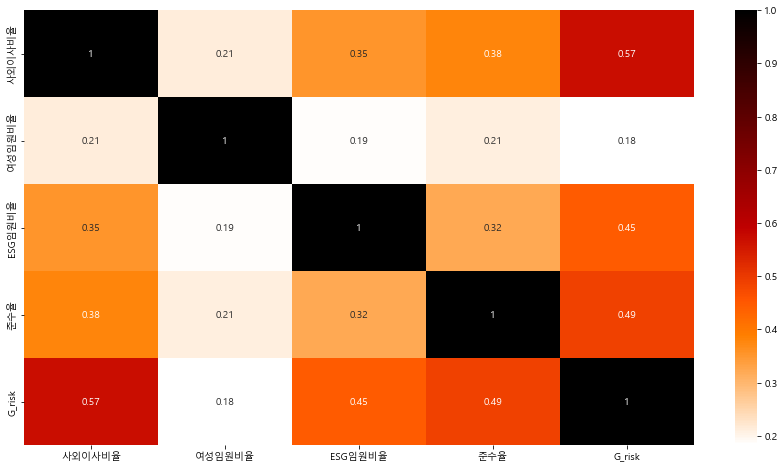

In [61]:
#correlation map
plt.figure(figsize = (15,8))
sns.heatmap(r_train[num_var].corr(), annot=True, cmap='gist_heat_r')
plt.show()

- 상관계수 plot에서도 특별히 위험한 수준의 상관관계는 없는 것으로 해석할 수 있다. 따라서 train set이 Multinomial Logistic Model을 사용하여 적합 할 수 있고, 그 결과는 신뢰할 수 있다고 말할 수 있다.

#### 주어진 train data set에 대해 Model Fitting : r_train 사용

In [175]:
## 선택한 모형 fitting
y_train = r_train['G_GRADE']
x_train = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False)

x = sm.add_constant(x_train, prepend=False)
model = sm.MNLogit(y_train, x) #모형 할당
result = model.fit(method='lbfgs', maxiter=100000) #모형 적합

mar=result.get_margeff()

y_pred = model.predict(result.params, x) #모형 예측
y_pred = y_pred.argmax(1) + 1 #이때, 모형이 예측한 값은 확률값이기 때문에 이를 이용하여 classification 진행
y_pred = pd.Series(y_pred)

## 모형 fitting 결과
print("[Logistic Regression Train Set Evaluation]")
eval_stat(confusion_matrix(y_train, y_pred))

[Logistic Regression Train Set Evaluation]
정확도 :  34.64 %
근접정확도 :  61.57 %
과소적합/오류 비 :  58.33 %
3등급이상과적합/오류 비 :  34.03 %


- 전체 train set을 이용하여 모형을 적합한 결과 정확도는 34.64%, 근접정확도는 61.57%, 과소적합/오류비는 58.33%, 3등급이상과적합/오류비는 34.03% 로 나타난다.

#### result confusion matrix
confusion matrix는 다음과 같다.

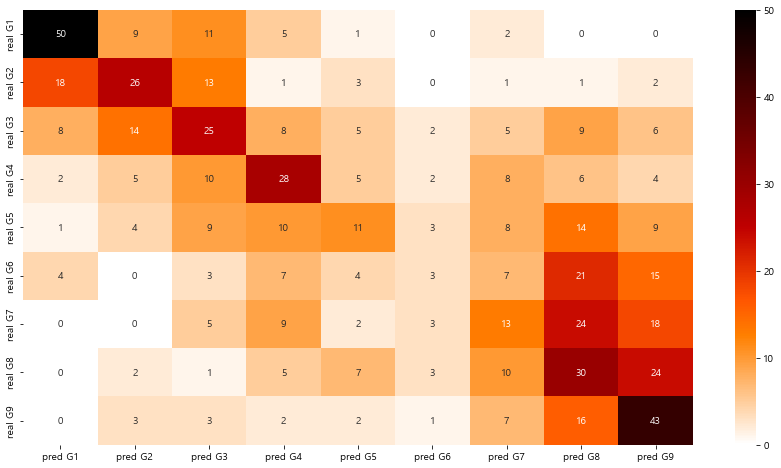

In [64]:
confmtrx = np.array(confusion_matrix(y_train, y_pred))
confmtrx = pd.DataFrame(confmtrx, index=['real G1','real G2','real G3','real G4','real G5','real G6','real G7', 'real G8',
                              'real G9']
             , columns=['pred G1','pred G2','pred G3','pred G4','pred G5','pred G6','pred G7','pred G8','pred G9'])

plt.figure(figsize = (15,8))
ax = sns.heatmap(confmtrx,annot=True,cmap='gist_heat_r')
plt.show()

#### Result 

In [176]:
print('### print marginal summary ###')
print(mar.summary())

# Pseudo R-squ. : 맥파든 의사결정계수 : 가장 성능이 좋을 때 1이고, 나쁠 때 0
# Log-Likelihood : 모든 covariate을 넣었을 때의 likelihood 값
# LL-Null : 아무 covariate도 없을 때의 likelihood 값
# LLR p-value : 귀무가설 : Saturated model에서 추가적으로 존재하는 설명 변수의 회귀계수들은 모두 0이다.
# -> p-value가 작으므로 기각 : 해당 모형의 설명변수들의 회귀계수들은 모두 0이 아니다.

print("### print model summary ###")
print(result.summary())

### print marginal summary ###
       MNLogit Marginal Effects      
Dep. Variable:                G_GRADE
Method:                          dydx
At:                           overall
 G_GRADE=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
지가경공시          0.0527      0.115      0.459      0.646      -0.172       0.278
주총ESG안건        0.0918      0.076      1.201      0.230      -0.058       0.242
사외이사비율         0.0264      0.016      1.654      0.098      -0.005       0.058
여성임원비율         0.0030      0.003      0.904      0.366      -0.004       0.010
ESG임원비율        0.0146      0.017      0.846      0.397      -0.019       0.048
준수율            0.0054      0.007      0.816      0.415      -0.008       0.018
배당공지           0.0415      0.034      1.217      0.224      -0.025       0.108
내부감사부서        -0.0121      0.026     -0.463      0.643      -0.063       0.039
감사전문가          0.0433      

                          MNLogit Regression Results                          
Dep. Variable:                G_GRADE   No. Observations:                  661
Model:                        MNLogit   Df Residuals:                      525
Method:                           MLE   Df Model:                          128
Date:                Sat, 15 Oct 2022   Pseudo R-squ.:                  0.2288
Time:                        17:06:01   Log-Likelihood:                -1118.1
converged:                       True   LL-Null:                       -1449.8
Covariance Type:            nonrobust   LLR p-value:                 3.495e-73
 G_GRADE=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
지가경공시          0.1206      0.598      0.202      0.840      -1.052       1.293
주총ESG안건       -0.5173      0.458     -1.130      0.258      -1.415       0.380
사외이사비율         0.1703      0.304      0.560      0.5

* marginal model에 대한 summary 해석
    - marginal model을 summary함으로써 나오는 결과값은 전체 모형보다 해석이 훨씬 쉽다. marginal의 경우는 $ln(\frac{P_(G_i)}{1-P_(G_i)})$에 대한 회귀계수를 의미하므로 좀 더 직관적이다. 
    - 회귀계수가 + 값을 가지면 그 설명변수가 커질수록 $G_i$ 카테고리에 대한 확률이 커진다는 뜻이며 회귀계수가 - 값을 가지면 그 설명변수가 커질수록 $G_i$ 카테고리에 대한 확률이 작아진다는 뜻이다.


* 전체 모형의 summary의 해석
    - 선택한 모형의 결과 값이다. 
    1. model summary 표에서 설명하는 내용은 다음과 같다.
        - Pseudo R-squ는 $R^2$값으로 결정계수라고도 불리며 1에 가까울 수록 좋은 설명력을 가진다. 
        - LL-Null은 아무 변수도 넣지 않고 상수만 존재하는 모형에서의 log-likelihood 값이다. 
        - LLR p-value는 가능도비검정의 p-value 값이다. 가능도비검정의 귀무가설은 'Full model에서 추가적으로 존재하는 회귀계수는 모두 0이다' 이다. 따라서 LLR p-value가 0.05보다 작으므로 귀무가설을 기각하여 Full model이 가진 회귀계수는 모두 0이 아니라고 할 수 있다. 즉, 아무 설명변수를 넣지 않은 모형보다는 현재 적합한 모델이 더 의미가 있다는 의미이다.  
  
    2. model summary 표의 회귀계수가 의미하는 바는 다음과 같다. 
        - 각 값은 G1을 base 카테고리로 하여 회귀계수를 추정한 값이다. 
        - 모델 식은 다음과 같다. $Y = ln(\frac{P}{1-P}) = \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k$. 일반적인 logistic regression에서는 Y의 범주가 2개이므로 단순하게 해석 가능하지만 Multinomial Logistic Regression의 경우는 범주가 여러개이기 때문에 해석이 다소 달라진다. 결과적으로 나오는 Y값은 다음과 같다. $ln(\frac{P_(categoryB)}{P_(categoryA)})$ 이때 category A가 base category를 의미한다. 또한 이 오즈를 relative log-odds라고 부른다.   
        - 따라서 다음과 같이 해석된다. 회귀계수는 해당 변수가 1 unit 증가했을 때, 어떤 y가 base category로 예측될 확률에 비해 해당 카테고리로 예측될 확률의 exp(회귀계수) 값 만큼 배가 된다. 이것을 결과에 대입해서 예시를 들어보면 다음과 같이 해석할 수 있다. 
        - 예를 들어 위 표에서 G_GRADE=2에 주총ESG안건의 coef 값인 -0.52이다. 이때 base category는 G1이다. 주총ESG안건이 1만큼 증가했을 때, 그 y가 G1으로 예측될 확률에 비해 G2로 예측될 확률이 $\exp(-0.52)$배만큼 커지게 된다. 따라서 주총ESG안건 값이 커지면 G1으로 예측될 확률에 비해 G2로 예측될 확률이 작아지게 되고, 이는 주총ESG안건값이 커지는 건 G1으로 예측되도록 도움이 된다는 의미이다.     
        - 결과적으로 회귀계수가 + 값을 가지면 그 설명변수가 커질수록 G1에 비해 다른 카테고리가 될 확률이 커진다는 의미이고, 회귀계수가 - 값을 가지면 그 설명변수가 커질수록 G1에 비해 다른 카테고리가 될 확률이 작아지게 된다는 의미이다.  



- 전체적으로 방향성도 우수하고 설명력도 가지고 있으며 LLR p-value도 유의하게 나온 것으로 보아 모델은 어느 정도 성능을 보장하지만 R-squ 값이 작아 설명력이 떨어지기 때문에 변수선택을 시행한다.

#### Result에 따른 variable selection
- AIC는 작을수록 좋기 때문에 전체 변수에서 제거했을 때 AIC가 가장 작아지는 변수를 제거하는 후진제거법으로 변수선택을 진행하였다.

In [66]:
# 초기값 입력
# x : 모델링 시 r_train의 covariate 값에 constant 부분을 더해준 train set
data = copy.deepcopy(x)
predictor=x.columns.difference(['const']) #x의 변수명

can_model = [] #후보가 될 model들이 들어갈 어레이 할당
candidate = [] #후보가 될 result들이 들어갈 어레이 할당
can_var = [] #제거되는 변수명이 들어갈 어레이 할당

model = sm.MNLogit(y_train, data)
regr = model.fit(method='lbfgs', maxiter=100000) #full model에 대해 모델 적합
can_model.append(model)
candidate.append(regr)
can_var.append('Full')

# 변수 선택 시작
for i in range(len(x.columns)-1) :
# for문 시작
    r_model=[]
    result=[]
    dropped=[]
    AIC = []
    
    #아무것도 제거하지 않은 full data에 대해 적합
    model = sm.MNLogit(y_train, data)
    regr = model.fit(method='lbfgs', maxiter=100000)
    r_model.append(model)
    result.append(regr)
    dropped.append('no')
    AIC.append(regr.aic)
    
    # 변수를 하나씩 제거하면서 data 적합하여 모델을 result에 저장
    # 제거한 변수는 dropped에 저장
    # 변수를 제거했을 때 나온 AIC는 AIC에 저장
    for var in predictor :
        model = sm.MNLogit(y_train, data.drop(var, inplace=False, axis=1))
        regr = model.fit(method='lbfgs', maxiter=100000)
        r_model.append(model)
        result.append(regr)
        dropped.append(var)
        AIC.append(regr.aic)

    # AIC가 가장 작은 best 모형을 찾기 위해 데이터프레임을 만들고 AIC 기준으로 sorting
    best = pd.DataFrame({'model':r_model,'model_result':result, 'AIC':AIC, 'dropped':dropped})
    best = best.sort_values(by='AIC', ascending=True, ignore_index=True)
    best.head(3) 
    can_model.append(best.loc[0,'model']) #가장 좋은 모델을 can_model에 저장
    candidate.append(best.loc[0,'model_result']) #가장 좋은 모델은 candidate에 저장
    can_var.append(best.loc[0,'dropped']) #가장 좋은 모델을 만들기 위해 버린 변수명을 can_var에 저장
    if best.loc[0,'dropped']=='no' :  # 만약 가장 좋은 모델로 Full model이 뽑힌다면 for문을 종료
        break
    data.drop(columns=best.loc[0,'dropped'], inplace=True)
    predictor=data.columns.difference(['const'])

# 비어있는 array할당해서 해당 모델의 AIC 값 저장  
AIC=[]
for i in range(len(candidate)) :
    AIC.append(candidate[i].aic)

# 비어있는 array 할당  
acc_vec=[]
nearest_acc_vec=[]
under_est_vec=[]
over3_est_vec=[]

data = copy.deepcopy(x)
real = r_train['G_GRADE']
for i in range(len(candidate)) :
    d_var = can_var[i]
    model = can_model[i]
    result = candidate[i]
    if d_var=='Full' :
        x=sm.add_constant(x_train, prepend=False)
        pred=model.predict(result.params,x)
        pred = pred.argmax(1) + 1
        pred = pd.Series(pred)
        m = confusion_matrix(real, pred)
        acc_vec.append(acc(m))
        nearest_acc_vec.append(nearest_acc(m))
        under_est_vec.append(under_est(m))
        over3_est_vec.append(over3_est(m))
    elif d_var=='no':
        pred=model.predict(result.params,data)
        pred = pred.argmax(1) + 1
        pred = pd.Series(pred)
        m = confusion_matrix(real, pred)
        acc_vec.append(acc(m))
        nearest_acc_vec.append(nearest_acc(m))
        under_est_vec.append(under_est(m))
        over3_est_vec.append(over3_est(m))
    else :
        data.drop(columns=d_var, inplace=True)
        pred=model.predict(result.params,data)
        pred = pred.argmax(1) + 1
        pred = pd.Series(pred)
        m = confusion_matrix(real, pred)
        acc_vec.append(acc(m))
        nearest_acc_vec.append(nearest_acc(m))
        under_est_vec.append(under_est(m))
        over3_est_vec.append(over3_est(m))
    
candidate_model = pd.DataFrame({'candidate_model':can_model,'result':candidate,'dropped':can_var, 'AIC':AIC, '정확도':acc_vec, 
                                '근접정확도':nearest_acc_vec, '과소추정오류비':under_est_vec, '3단계과추정률':over3_est_vec})
# 후진 제거법으로 선택한 모형
candidate_model.drop(columns=['candidate_model','result'], inplace=False)

,dropped,AIC,정확도,근접정확도,과소추정오류비,3단계과추정률
0,Full,2508.229912,0.346445,0.615734,0.583333,0.340278
1,불성실공시,2495.294027,0.337368,0.617247,0.582192,0.324201
2,지가경공시,2483.255508,0.338880,0.618759,0.581236,0.327231
3,내부감사부서,2472.772197,0.346445,0.609682,0.592593,0.342593
4,여성임원비율,2464.608480,0.335855,0.605144,0.617312,0.334852
5,준수율,2458.421632,0.335855,0.603631,0.599089,0.341686
6,배당공지,2452.998700,0.344932,0.614221,0.581986,0.344111
7,횡령3y,2447.532365,0.331316,0.608169,0.585973,0.346154
8,지배구조공시,2444.033990,0.325265,0.614221,0.576233,0.327354
9,no,2444.033990,0.325265,0.614221,0.576233,0.327354


- 후진 제거법으로 선택된 모형들에 대한 정보는 위와 같다. 제거된 변수는 불성실공시, 지가경공시, 내부감사부서, 여성임원비율, 준수율, 배당공지, 횡령3y, 지배구조공시이다.

In [68]:
## 선택한 모형들의 AIC, dropped variable, summary 출력
for i in range(candidate_model.shape[0]) :
    print('### ', i, 'th selected model ###')
    print("AIC: ", candidate_model.loc[i,'AIC'], "dropped value: ", candidate_model.loc[i,'dropped'])
    print(check_beta(candidate_model.loc[i,'result']))
    

###  0 th selected model ###
AIC:  2508.229912354779 dropped value:  Full
0         지가경공시     주총ESG안건      사외이사비율      여성임원비율     ESG임원비율         준수율  \
G=2      0.1206     -0.5173      0.1703     -0.0517     -0.0399      0.0105   
G=3     -0.3422     -0.6713     -0.5366     -0.0769     -0.1379     -0.0955   
G=4      0.0574     -2.6827     -0.3842      0.0318     -0.3433     -0.2009   
G=5     -0.9406     -2.3770     -1.0467     -0.0708     -0.2946     -0.2144   
G=6     -6.5024     -0.4885     -1.7442     -0.0643     -1.2472     -0.1497   
G=7     -3.4439     -8.7563     -1.3883      0.0214     -1.3037     -0.2483   
G=8     -5.7803     -0.8268     -1.8656     -0.0416     -0.2624     -0.1680   
G=9     -5.8361     -8.0688     -1.4260     -0.0860     -0.1020     -0.1432   

0          배당공지      내부감사부서       감사전문가      공시우수법인        횡령3y      지배구조공시  \
G=2     -0.7019     -0.0033      0.3098     -0.6799     -0.9495      0.0057   
G=3     -0.4082      0.3039     -1.4889     -1.0593     

- 위 후진제거법으로 선택한 모형들의 AIC, 각 단계마다 제거된 변수, summary를 통해 얻은 회귀계수 값을 출력한다. 
- 제시된 모형의 4가지 지표를 보고 summary결과 맨 마지막 모델이 선택한 변수를 사용하기로 결정했다. 
- 제거된 변수는 [불성실공시, 지가경공시, 내부감사부서, 여성임원비율, 준수율, 배당공지, 횡령3y, 지배구조공시]이다. 
- 남은 변수는 [주총ESG안건, 사외이사비율, ESG임원비율, 감사전문가, 공시우수법인, 지가경발간, G_risk, 이사회독립성_독립]이다.

#### variable selection에 따른 Final Fitting

In [200]:
## variable selection에 따라 data에 불필요한 covariate들을 delete
y_train = r_train['G_GRADE']
x_train = r_train.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False)
x_train = x_train[['주총ESG안건','사외이사비율','ESG임원비율','감사전문가','공시우수법인','지가경발간','G_risk','이사회독립성_독립']]
x = sm.add_constant(x_train, prepend=False)
model = sm.MNLogit(y_train, x)
result = model.fit(method='lbfgs', maxiter=100000)
mar=result.get_margeff()
y_pred = model.predict(result.params, x)
y_pred = y_pred.argmax(1) + 1
y_pred = pd.Series(y_pred)
## 모형 fitting 결과
print("[Logistic Regression Train Set Evaluation]")
eval_stat(confusion_matrix(y_train, y_pred))

[Logistic Regression Train Set Evaluation]
정확도 :  32.53 %
근접정확도 :  61.42 %
과소적합/오류 비 :  57.62 %
3등급이상과적합/오류 비 :  32.74 %


- AIC를 기준으로 변수를 선택한 후, train set에 대해서 fitting 한 결과는 다음과 같다. 
- 정확도는 32.53%, 근접정확도는 61.42%, 과소적합/오류비는 57.62%, 3등급이상과적합오류비는 32.74%이다. 
- 모든 변수를 사용했을 때와 클수록 좋은 정확도, 근접정확도의 경우 변수 선택 이후 작은 폭이기는 하지만 감소했고, 과소적합오류비의 경우 변수 선택 이후 증가했다. 작을수록 좋은 3등급이상과적합오류비는 역시 감소했다. 좋지 않은 쪽으로는 아주 작은 폭으로 변했고, 3등급이상과적합오류비는 2%정도가 줄어들어 변수선택이 타당하다고 판단했다.

In [136]:
print("### print model summary ###")
print(result.summary())

### print model summary ###
                          MNLogit Regression Results                          
Dep. Variable:                G_GRADE   No. Observations:                  661
Model:                        MNLogit   Df Residuals:                      589
Method:                           MLE   Df Model:                           64
Date:                Sat, 15 Oct 2022   Pseudo R-squ.:                  0.2068
Time:                        12:44:27   Log-Likelihood:                -1150.0
converged:                       True   LL-Null:                       -1449.8
Covariance Type:            nonrobust   LLR p-value:                 5.136e-88
G_GRADE=_1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
주총ESG안건        8.3472     31.206      0.267      0.789     -52.815      69.510
사외이사비율         1.2986      0.309      4.208      0.000       0.694       1.903
ESG임원비율        0.1273   

- 또한 summary의 결과 R-squ값이 0.2068으로 전체 변수를 사용한 full model의 0.2288보다 작아져 설명력이 줄어들었다고 할 수 있지만 여전히 LLR p-value가 작고, 위 4가지 지표에서 설명했던 것과 같은 논리로 변수선택이 합당하다고 판단했다.

#### variale selection 이후, 전체 모델에 대한 회귀계수 값 출력

In [80]:
print('### The selected model\'s regression coefficient ###')
check_beta(result)

### The selected model's regression coefficient ###


,주총ESG안건,사외이사비율,ESG임원비율,감사전문가,공시우수법인,지가경발간,G_risk,이사회독립성_독립,const
G=2,-0.5378,0.1349,-0.0321,0.3039,-0.7081,-0.3463,-0.3687,-0.9157,0.4788
G=3,-0.6623,-0.5318,-0.1296,-0.9203,-0.8599,-0.4114,-0.2668,-0.3628,1.2730
G=4,-2.6056,-0.2916,-0.3421,-1.0325,-1.8075,-0.8375,-0.5012,-0.9053,0.3806
G=5,-2.2572,-1.0586,-0.2943,-1.5715,-2.2714,-1.3021,-0.3067,-0.2037,0.7409
G=6,-0.4111,-1.6149,-1.4403,-1.2603,-11.1173,-1.8892,-0.5357,0.1476,-5.5967
G=7,-9.6756,-1.3710,-1.4763,-1.4100,-3.6228,-9.9926,-0.6695,-0.5793,-5.3806
G=8,-0.7984,-1.7403,-0.2622,-1.5878,-11.2552,-2.4551,-0.7278,-2.1045,0.7982
G=9,-9.1742,-1.2990,-0.1265,-1.0771,-3.8966,-1.3414,-1.9453,0.6953,0.6856


#### variable selection 이후, 전체 모형에 대한 p-value 값 출력

In [92]:
print('### The selected model\'s regression coefficient\' p-value is ###')
check_p_value(result)

### The selected model's regression coefficient' p-value is ###


,주총ESG안건,사외이사비율,ESG임원비율,감사전문가,공시우수법인,지가경발간,G_risk,이사회독립성_독립,const
G=2,0.225,0.614,0.635,0.583,0.162,0.418,0.327,0.047,0.362
G=3,0.182,0.057,0.114,0.080,0.104,0.357,0.483,0.435,0.018
G=4,0.016,0.321,0.033,0.062,0.009,0.129,0.201,0.113,0.666
G=5,0.040,0.000,0.078,0.007,0.003,0.048,0.447,0.720,0.414
G=6,0.567,0.000,0.865,0.037,0.808,0.024,0.191,0.808,0.899
G=7,0.834,0.000,0.867,0.021,0.001,0.813,0.094,0.388,0.906
G=8,0.322,0.000,0.156,0.013,0.807,0.027,0.068,0.061,0.420
G=9,0.846,0.000,0.497,0.110,0.001,0.153,0.000,0.318,0.490


#### variable selection 이후, marginal model에 대한 회귀계수 값 출력

In [179]:
check_beta_mar(mar)

,주총ESG안건,사외이사비율,ESG임원비율,감사전문가,공시우수법인,지가경발간,G_risk,이사회독립성_독립
G_GRADE=1,0.0967,0.0268,0.0158,0.0357,0.1297,0.0649,0.0273,0.0417
G_GRADE=2,0.0858,0.0511,0.0186,0.0792,0.1073,0.0594,-0.0022,-0.0438
G_GRADE=3,0.2004,0.0204,0.0298,-0.0093,0.2734,0.1520,0.0263,0.0155
G_GRADE=4,0.0289,0.0565,0.0102,-0.0049,0.1895,0.1272,0.0069,-0.0408
G_GRADE=5,0.1022,-0.0062,0.0240,-0.0468,0.2272,0.1187,0.0333,0.0328
G_GRADE=6,0.2941,-0.0467,-0.0832,-0.0063,-0.5651,0.0766,0.0148,0.0660
G_GRADE=7,-0.6603,-0.0256,-0.1005,-0.0216,0.1734,-0.8039,0.0062,-0.0053
G_GRADE=8,0.3674,-0.0650,0.0403,-0.0416,-0.6857,0.0513,0.0036,-0.1887
G_GRADE=9,-0.5153,-0.0113,0.0450,0.0157,0.1503,0.1539,-0.1163,0.1225


#### variable selection 이후, marginal model에 대한 p-value 값 출력

In [180]:
check_p_value_mar(mar)

,주총ESG안건,사외이사비율,ESG임원비율,감사전문가,공시우수법인,지가경발간,G_risk,이사회독립성_독립
G_GRADE=1,0.475,0.064,0.640,0.225,0.450,0.519,0.193,0.079
G_GRADE=2,0.718,0.001,0.708,0.007,0.666,0.731,0.914,0.129
G_GRADE=3,0.743,0.221,0.809,0.772,0.669,0.728,0.237,0.670
G_GRADE=4,0.968,0.000,0.937,0.871,0.767,0.800,0.708,0.331
G_GRADE=5,0.905,0.667,0.884,0.170,0.792,0.846,0.075,0.400
G_GRADE=6,0.742,0.000,0.907,0.846,0.883,0.900,0.373,0.094
G_GRADE=7,0.881,0.049,0.904,0.570,0.878,0.839,0.710,0.919
G_GRADE=8,0.777,0.000,0.859,0.331,0.879,0.951,0.827,0.060
G_GRADE=9,0.896,0.354,0.804,0.699,0.888,0.826,0.000,0.011


#### Interpretation and Visualization

In [181]:
new_num_var = ['사외이사비율','ESG임원비율','G_risk']
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
   x_train[new_num_var].values, i) for i in range(x_train[new_num_var].shape[1])]
vif["features"] = x_train[new_num_var].columns
print("### Train set VIF ###")
vif

### Train set VIF ###


,VIF Factor,features
0,1.490476,사외이사비율
1,1.036253,ESG임원비율
2,1.501218,G_risk


- 변수 선택 후에도 vif지수나 상관계수 행렬을 그려봤을 때, 눈에 띄게 문제가 될 만한 값을 발생하지 않으므로, 변수선택 후 모델링의 결과가 신뢰할 수 있다고 판단했다.

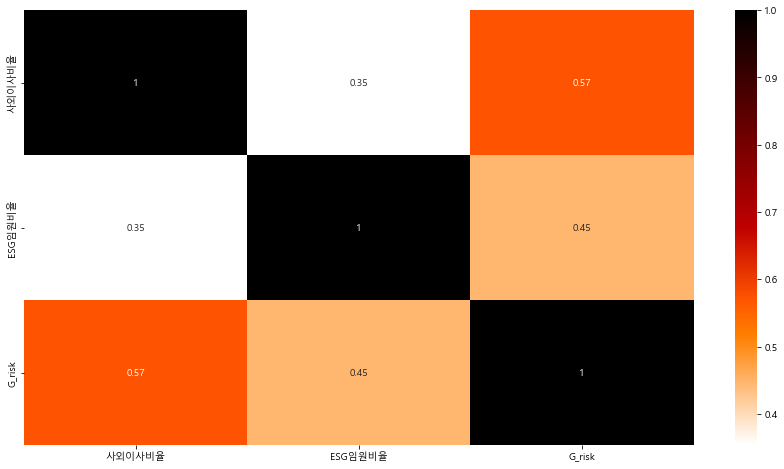

<Figure size 432x288 with 0 Axes>

In [201]:
plt.figure(figsize = (15,8))
sns.heatmap(x_train[new_num_var].corr(), annot=True,cmap='gist_heat_r')
plt.show()

## 5. Estimation
- r_test 사용 (scaling 및 dummy 생성 완료된 데이터)

In [82]:
# 추가로 drop할 변수 있으면 drop해주기
x_test = r_test.drop(columns=['종목코드','회사명','SICS_Sector_Kr','G_GRADE','Stratify'], 
                     inplace=False, )
x_test = x_test[['주총ESG안건','사외이사비율','ESG임원비율','감사전문가','공시우수법인','지가경발간','G_risk','이사회독립성_독립']]
x_test = sm.add_constant(x_test, prepend=False)
pred = model.predict(result.params, x_test)
pred = pred.argmax(1) + 1

G_result = copy.deepcopy(r_test)
G_result['pred_grade'] = pred
G_result=G_result[['종목코드','회사명','SICS_Sector_Kr','pred_grade']]

In [83]:
# G_result 데이터프레임 확인
G_result.head(5) 

,종목코드,회사명,SICS_Sector_Kr,pred_grade
0,95570,AJ네트웍스,자원 변환,5
1,6840,AK홀딩스,자원 변환,3
2,27410,BGF,식음료,4
3,1460,BYC,소비재,7
4,1040,CJ,식음료,2


In [182]:
#G_result 값 저장
G_result.to_csv("G_result.csv", index=False, encoding="utf-8-sig")